# Imports

In [16]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyxdf
from glob import glob

# Load Data

In [17]:
sub_files = glob('../../../*/*.xdf')
sub_files


['../../../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [18]:
xdf_path = sub_files[3]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['WebcamStream',
 'Tobii',
 'OpenSignals',
 'EGI NetAmp 0',
 'Stimuli_Markers',
 'Microphone']

In [19]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
ps_df

,nSeq,RESPIRATION0,ECG1,EDA2,fSpO23,fSpO24,%SpO25,lsl_time_stamp,time
0,110775.0,-0.02582,1.45963,2.6134,0.55642,1.06794,27.0,1.073908e+06,0.000000
1,110776.0,-0.02637,1.46269,2.6154,0.55640,1.06793,27.0,1.073908e+06,0.000002
2,110777.0,-0.02582,1.45568,2.6161,0.55640,1.06793,27.0,1.073908e+06,0.000004
3,110778.0,-0.02618,1.44463,2.6161,0.55637,1.06789,27.0,1.073908e+06,0.000006
4,110779.0,-0.02582,1.43448,2.6173,0.55631,1.06791,27.0,1.073908e+06,0.000008
...,...,...,...,...,...,...,...,...,...
1176795,1287570.0,-0.01520,-0.34941,7.1915,0.53018,1.08721,22.0,1.076263e+06,2.354392
1176796,1287571.0,-0.01474,-0.27475,7.1899,0.53009,1.08728,22.0,1.076263e+06,2.354394
1176797,1287572.0,-0.01520,-0.21240,7.1884,0.53009,1.08732,22.0,1.076263e+06,2.354396
1176798,1287573.0,-0.01520,-0.15220,7.1899,0.53015,1.08730,22.0,1.076263e+06,2.354398


In [20]:
srate = PS['info']['effective_srate']

rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp_df

,respiration,lsl_time_stamp
0,-0.02582,1.073908e+06
1,-0.02637,1.073908e+06
2,-0.02582,1.073908e+06
3,-0.02618,1.073908e+06
4,-0.02582,1.073908e+06
...,...,...
1176795,-0.01520,1.076263e+06
1176796,-0.01474,1.076263e+06
1176797,-0.01520,1.076263e+06
1176798,-0.01520,1.076263e+06


# Data Time

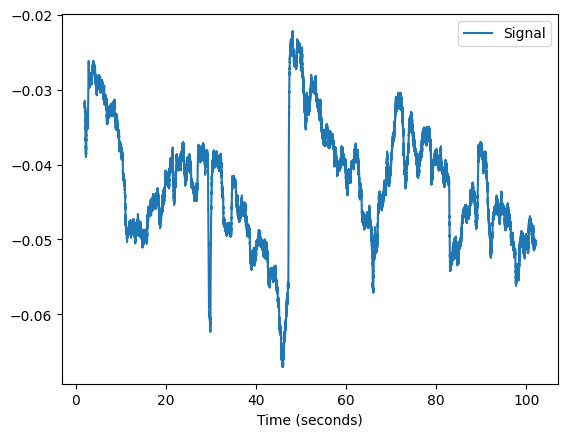

In [22]:
# raw
# 100 seconds * 500 samps/second = 50000 samps
nk.signal_plot(rsp_df.respiration[1000:51000], sampling_rate=srate)